In [1]:
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from neuron import h, gui

In [16]:
h.cvode_active(0)

0.0

# Using original RM03 model and interface to NEURON

In [17]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %02.2e cm^2, diameter: %02.2f um'%(soma_area,soma_diam)
# Isn't it a bit too large a diameter? -> No, it's OK


Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [18]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [19]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [20]:

typeII = {cond:ns_to_mhocm2(val) for cond, val in 
 [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
  ('gabar', 0),  ('ghbar', 20),   ('glk', 2), ]}

typeII['glk'] = 0
typeII['Vm0'] = -63.6
# in S/cm^2
typeII

{'Vm0': -63.6,
 'gabar': 0.0,
 'ghbar': 0.0016666666666666666,
 'gkhtbar': 0.0125,
 'gkltbar': 0.016666666666666666,
 'glk': 0,
 'gnabar': 0.08333333333333334}

In [21]:
bushy = h.Section(name='bushy') 
bushy.nseg=1
bushy.diam = soma_diam
bushy.L = soma_diam
bushy.Ra = 150
bushy.cm = 1

In [22]:
for cur in currents:
    bushy.insert(cur)

In [23]:
bushy.ek = -70
bushy.ena = 50
bushy.gbar_hcno = 0

bushy.gnabar_na = typeII['gnabar']
bushy.gkhtbar_kht = typeII['gkhtbar']
bushy.gkltbar_klt = typeII['gkltbar']
bushy.gkabar_ka = typeII['gabar']
bushy.ghbar_ih = typeII['ghbar']
bushy.g_leak = typeII['glk']

In [24]:
h.psection(bushy)

1.0

In [25]:
v_vec = h.Vector()             # Membrane potential vector
t_vec = h.Vector()             # Time stamp vector
v_vec.record(bushy(0.5)._ref_v)
t_vec.record(h._ref_t)


1.0

In [26]:
h.v_init = typeII['Vm0']

In [27]:
h.tstop = 2000

In [28]:
h.run()

0.0

(-70, -50)

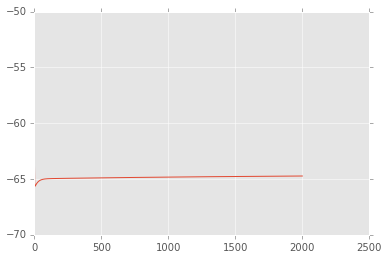

In [108]:
plot(t_vec, v_vec);
ylim(-70,-50)

In [30]:
bushy.v

-63.518161789521216

In [31]:
seg = bushy(0.5)

In [32]:
seg.ih.i*0.2 + seg.ina

-0.0010594020405146315

In [33]:
seg.ih.i*0.8 + seg.ik

0.0010594059638932415

In [34]:
gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
gkr = seg.ik/(seg.v-seg.ek)
ghr = seg.i_ih/(seg.v- -43)
glkr = seg.leak.i/(seg.v -seg.erev_leak)


Rin_t2 = 71.0 # From Rothman and Manis 2003

# From model:
Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
Rin_t2x = 1e-6/Ginx 

print Rin_t2, 'in cit., in model:', Rin_t2x, 'MOhm'

71.0 in cit., in model: 81.9637138282 MOhm


In [35]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [36]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou

In [37]:
rATP_bushy  = ratp_atwell(bushy.v, Rin_t2x, Ek=-70)

print\
"""Оценка по Attwell: {:.3e} pmol ATP/сек
                 : {:.3e} pJ/s""".format(rATP_bushy, atp2J(rATP_bushy))

Оценка по Attwell: 3.775e-04 pmol ATP/сек
                 : 1.887e+01 pJ/s


In [179]:
def mouj_Erate(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc += seg.ina*(v-seg.ena) 
    acc += seg.ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak)
    acc += seg.ih.i*(v-erev_ih)
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def hasegawa_Erate(seg, Iap=0,erev_ih = -43):
    v = seg.v
    acc = Iap*v
    acc -= seg.ina*seg.ena 
    acc -= seg.ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    acc -= seg.ih.i*erev_ih
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [39]:
dH_bushy2 = mouj_Erate(bushy(0.5))
dH_bushy3 = hasegawa_Erate(bushy(0.5))

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [40]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 3.408e-05 pmole ATP/сек
                            : 1.704e+00 pJ/s


In [41]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 3.408e-05 pmole ATP/сек
                  : 1.704e+00 pJ/s


Attwell to Moujahid ratio:

In [42]:
rATP_bushy/rATP_bushy2

11.077424614117765

In [60]:
def split_ih(seg, gratio=4, eh=-43):
    "splits ih to Na and K components (crude)"
    v = seg.v
    gnah = seg.ih.i/(v*(gratio+1) - gratio*seg.ek - seg.ena)
    inah = gnah*(v-seg.ena)
    ikh = gratio*gnah*(v-seg.ek)
    return inah, ikh

In [66]:
inah, ikh = split_ih(seg)
print inah, ikh

jk = (bushy.ik + ikh)*soma_area/F # mmol/s
jna = (bushy.ina + inah)*soma_area/F

## В текущей модели, получается, что jk=jna, что сложно совместимо
## со стехиометрией Na,K-АТФ-азы

print allclose(jk,jna)

jatp_na = -jna/3
jatp_k = jk/2


print '%0.3e'%(jatp_na*1e9), 'pmol ATP/s [from jNa]'
print '%03e'%(jatp_k*1e9), 'pmol ATP/s [from jK]'

-0.00263850986448 0.00211646624823
True
2.035e-04 pmol ATP/s [from jNa]
5.487437e-03 pmol ATP/s [from jK]


А это близко к тому, что дает оценка по  Attwell (хотя бы по порядку величин)...

**Можем ли мы найти такой ток, при котором iNa:iK = 3:2 в стационарном состоянии?** -> Это будет током ipump

In [67]:
istim = h.IClamp(bushy(0.5))

In [72]:
istim.delay = 0.01
istim.dur = 10000
amps = linspace(-1,1,10)
amps = concatenate([amps, linspace(-0.25,0.25,100)])
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 2000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

(-1, 1)

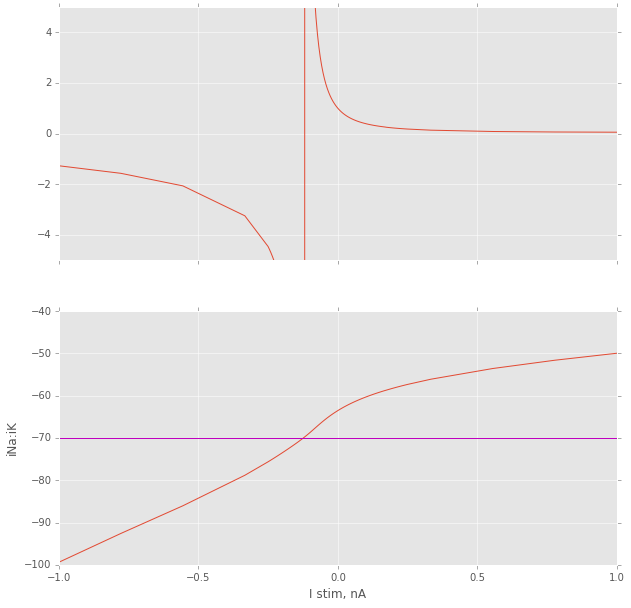

In [77]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0], ylim=(-5,5))
ylabel('iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')
xlim(-1,1)


In [86]:
Icut= amps[argmin((array(vrest)+70)**2)]
Icut

-0.12373737373737373

In [131]:
istim.delay = 0.01
istim.dur = 20000
#amps = linspace(-1,1,10)
amps = linspace(-0.04, -0.01, 10)
amps = sorted(amps)
cur_ratio = []
vrest = []
h.tstop = 10000
for amp in amps:
    istim.amp = amp
    h.run()
    inah,ikh = split_ih(seg)
    ina = (bushy.ina + inah)
    ik = (bushy.ik + ikh)
    vrest.append(seg.v)
    cur_ratio.append(ina/ik)

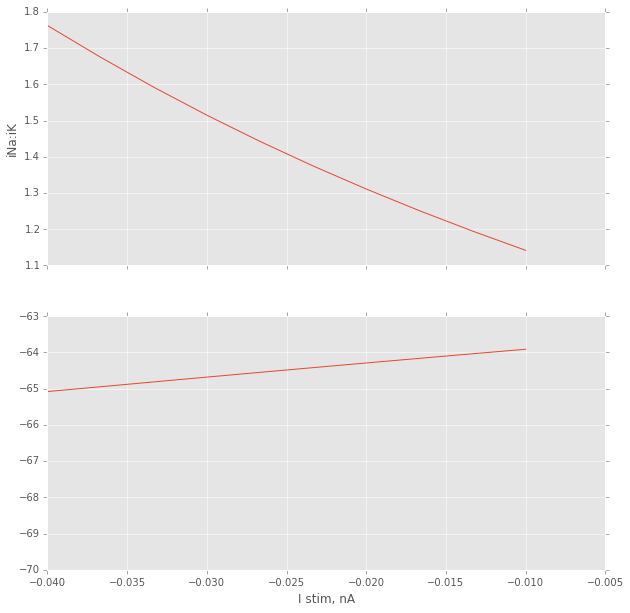

In [141]:
f, axs = subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(amps, -array(cur_ratio))
setp(axs[0],  ylabel='iNa:iK')
axs[1].plot(amps, vrest)
axs[1].axhline(-70, color='m')
xlabel('I stim, nA')

-0.03


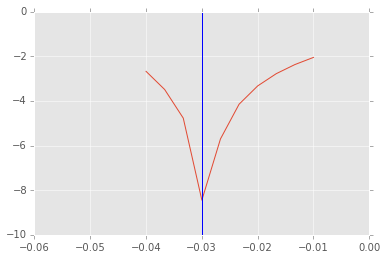

In [142]:
cr = -array(cur_ratio)
score = (cr-1.5)**2
plot(amps, log(score))
axvline(amps[argmin(score)])
ylim(-10,0)
xlim(-0.06, 0)
print amps[argmin(score)]

Ipump получился 0.03 nA

In [148]:
ip = amps[argmin(score)]
ip

-0.030000000000000002

In [144]:
'New estimate: %.3e'%((-ip/F)*1e3), 'pmole ATP/s'

('New estimate: 3.109e-04', 'pmole ATP/s')

In [168]:
ip

-0.030000000000000002

In [169]:
istim.amp = ip
h.v_init=-60
h.tstop=10000
h.dt = 0.025


h.run()

0.0

In [170]:
print seg.v

inah, ikh = split_ih(seg)

print 'Current ratio:', -(inah + bushy.ina) / (ikh + bushy.ik)
print 'Sum current:', (inah + bushy.ina) + (ikh+bushy.ik)

-64.6818354261
Current ratio: 1.51464790028
Sum current: -0.00250000870656


In [175]:
ipumpx = -(inah + bushy.ina)*soma_area/(F*3)

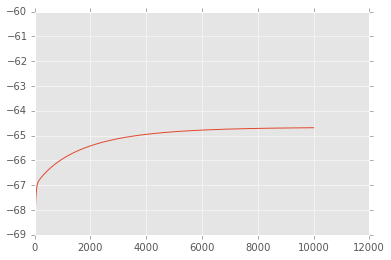

In [147]:
plot(t_vec, v_vec)

**Note** Только за эти времена токи уже устаканиваются, поэтому долго считать. Надо что ли алгебраически вывести...

In [180]:
dH_bushy2 = mouj_Erate(bushy(0.5),ip)
dH_bushy3 = hasegawa_Erate(bushy(0.5),ip)

rATP_bushy2 = nJ2atp(dH_bushy2)
rATP_bushy3 = nJ2atp(dH_bushy3)

In [181]:
print\
"""Оценка по Moujahid & D'Anjou: {:.3e} pmole ATP/сек
                            : {:.3e} pJ/s""".format(rATP_bushy2, dH_bushy2)

Оценка по Moujahid & D'Anjou: 5.025e-04 pmole ATP/сек
                            : 2.512e+01 pJ/s


In [182]:
print\
"""Оценка по Hasegawa: {:.3e} pmole ATP/сек
                  : {:.3e} pJ/s""".format(rATP_bushy3, dH_bushy3)

Оценка по Hasegawa: 4.637e-04 pmole ATP/сек
                  : 2.318e+01 pJ/s


In [183]:
print 'Новая оценка по Attwell: %.3e'%((-ipumpx*1e9)), 'pmol ATP/s'

Новая оценка по Attwell: -3.050e-04 pmol ATP/s
